In [1]:
import pandas as pd
import prophet

/home/david/proyectos4/p4_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

dir_notebook = os.getcwd()
print(dir_notebook)

/home/david/proyectos4/repositorios/Proyectos-SGBA1/Pruebas/Modelos


In [ ]:
ruta_trabajo = '../../../'

# Cambiar el directorio de trabajo
os.chdir(ruta_trabajo)

print("Directorio de trabajo actual:", os.getcwd())

Directorio de trabajo actual: /home/david/proyectos4/repositorios/Proyectos-SGBA1


In [4]:
!pwd

/home/david/proyectos4/repositorios/Proyectos-SGBA1


In [7]:
df_precios = pd.read_csv('data/processed/datos_precio/precio_consumo_electrico_timestamp_media.csv')
df_precios.head()

,timestamp,consumo_kwh,coste_euros,€/kwh
0,2014-11-02 01:00:00,0.0,0.0,NaN
1,2014-11-02 02:00:00,0.0,0.0,NaN
2,2014-11-02 03:00:00,0.0,0.0,NaN
3,2014-11-02 04:00:00,0.0,0.0,NaN
4,2014-11-02 05:00:00,0.0,0.0,NaN


In [6]:
df_climas = pd.DataFrame()

for file in os.listdir('data/processed/datos_clima/'):
    if file.endswith('clima_completo.csv'):
        idema = file.split('_')[0]
        print(idema)
        df_temp = pd.read_csv('data/processed/datos_clima/' + file)
        # print(df_temp.columns)
        # print(df_temp.head())
        # convertir a numerioc las columas de temperatura media minima y maxima
        # la de humedad relativa, la de valocidad del viento y el sol
        columnas_numericas = ['tmed', 'tmin', 'tmax', 'velmedia','sol', 'presMax', 'presMin', 'hrMedia']
        for col in columnas_numericas:
            if col in df_temp.columns:
                # First, convert string columns to ensure proper formatting
                if df_temp[col].dtype == 'object':
                    # Replace commas with dots (European number format)
                    df_temp[col] = df_temp[col].astype(str).str.replace(',', '.', regex=False)
                    
                    # Remove any spaces
                    df_temp[col] = df_temp[col].str.strip()
                
            # Convert to numeric, forcing any non-convertible value to NaN
            df_temp[col] = pd.to_numeric(df_temp[col], errors='coerce')
            
            # Check how many NaN values were created
            nan_count = df_temp[col].isna().sum()
            if nan_count > 0:
                print(f"Column {col}: {nan_count} values converted to NaN")

        df_temp['fecha'] = pd.to_datetime(df_temp['fecha'])
        
        # Rename columns with idema prefix to avoid conflicts when concatenating
        columns_to_rename = [col for col in columnas_numericas if col in df_temp.columns]
        rename_dict = {col: f"{idema}_{col}" for col in columns_to_rename}
        df_temp = df_temp.rename(columns=rename_dict)

        # Drop de el resto de columnas menos la fecha
        df_temp = df_temp.drop(columns=[col for col in df_temp.columns if col not in ['fecha'] + list(rename_dict.values())])

        if df_climas.empty:
            df_climas = df_temp.copy()
        else:
            df_climas = pd.merge(df_climas, df_temp, on='fecha', how='outer')
        

3196
Column tmed: 2 values converted to NaN
Column tmin: 2 values converted to NaN
Column tmax: 2 values converted to NaN
Column presMax: 1 values converted to NaN
Column presMin: 1 values converted to NaN
Column hrMedia: 1 values converted to NaN
9434
Column velmedia: 1 values converted to NaN
Column sol: 19 values converted to NaN
Column presMax: 2 values converted to NaN
Column presMin: 3 values converted to NaN
Column hrMedia: 3 values converted to NaN
1505
Column velmedia: 7 values converted to NaN
Column sol: 7 values converted to NaN
Column presMax: 8 values converted to NaN
Column presMin: 8 values converted to NaN
Column hrMedia: 9 values converted to NaN
3469A
9170
Column tmed: 1 values converted to NaN
Column tmin: 1 values converted to NaN
Column tmax: 1 values converted to NaN
Column velmedia: 25 values converted to NaN
Column sol: 3 values converted to NaN
Column presMax: 7 values converted to NaN
Column presMin: 7 values converted to NaN
Column hrMedia: 9 values converte

In [7]:
print(df_climas.shape)

(2520, 97)


In [8]:
# Convert timestamp to datetime if it's not already
df_precios['timestamp'] = pd.to_datetime(df_precios['timestamp'])

# Extract date part and create a new column for merging
df_precios['fecha'] = pd.to_datetime(df_precios['timestamp'].dt.date)

# Juntar los datos de precio y clima
df = pd.merge(df_precios, df_climas, on='fecha', how='inner')

In [9]:
df.tail()

,timestamp,coste_euros,fecha,3196_tmed,3196_tmin,3196_tmax,3196_velmedia,3196_sol,3196_presMax,3196_presMin,...,0200E_presMin,0200E_hrMedia,8175_tmed,8175_tmin,8175_tmax,8175_velmedia,8175_sol,8175_presMax,8175_presMin,8175_hrMedia
57620,2021-05-30 20:00:00,0.102559,2021-05-30,24.6,17.1,32.1,3.3,11.8,939.5,934.2,...,969.4,54.0,22.2,15.8,28.7,5.3,9.3,938.2,934.6,47.0
57621,2021-05-30 21:00:00,0.091213,2021-05-30,24.6,17.1,32.1,3.3,11.8,939.5,934.2,...,969.4,54.0,22.2,15.8,28.7,5.3,9.3,938.2,934.6,47.0
57622,2021-05-30 22:00:00,0.094615,2021-05-30,24.6,17.1,32.1,3.3,11.8,939.5,934.2,...,969.4,54.0,22.2,15.8,28.7,5.3,9.3,938.2,934.6,47.0
57623,2021-05-30 23:00:00,0.078302,2021-05-30,24.6,17.1,32.1,3.3,11.8,939.5,934.2,...,969.4,54.0,22.2,15.8,28.7,5.3,9.3,938.2,934.6,47.0
57624,2021-05-31 00:00:00,0.065628,2021-05-31,25.0,17.9,32.0,4.4,10.3,936.5,932.0,...,967.4,54.0,20.3,13.7,26.9,4.7,4.3,936.2,932.5,46.0


Prophet

In [13]:
df_prophet = df.copy()

In [14]:
# Modificamos los datos para prophet
df_prophet = df_prophet.rename(columns={'timestamp': 'ds', 'coste_euros': 'y'})
df_prophet = df_prophet.drop(columns=['fecha'])
df_prophet.head()

,ds,y,3196_tmed,3196_tmin,3196_tmax,3196_velmedia,3196_sol,3196_presMax,3196_presMin,3196_hrMedia,...,0200E_presMin,0200E_hrMedia,8175_tmed,8175_tmin,8175_tmax,8175_velmedia,8175_sol,8175_presMax,8175_presMin,8175_hrMedia
0,2014-11-03 00:00:00,0.0,11.5,8.0,15.0,6.1,1.1,938.3,921.7,81.0,...,955.2,94.0,13.9,8.2,19.6,5.0,9.1,937.0,925.7,63.0
1,2014-11-03 01:00:00,0.0,11.5,8.0,15.0,6.1,1.1,938.3,921.7,81.0,...,955.2,94.0,13.9,8.2,19.6,5.0,9.1,937.0,925.7,63.0
2,2014-11-03 02:00:00,0.0,11.5,8.0,15.0,6.1,1.1,938.3,921.7,81.0,...,955.2,94.0,13.9,8.2,19.6,5.0,9.1,937.0,925.7,63.0
3,2014-11-03 03:00:00,0.0,11.5,8.0,15.0,6.1,1.1,938.3,921.7,81.0,...,955.2,94.0,13.9,8.2,19.6,5.0,9.1,937.0,925.7,63.0
4,2014-11-03 04:00:00,0.0,11.5,8.0,15.0,6.1,1.1,938.3,921.7,81.0,...,955.2,94.0,13.9,8.2,19.6,5.0,9.1,937.0,925.7,63.0


In [15]:
# Generamos train y test
# En test dejamos los ultimos 7 días
df_prophet_train = df_prophet.iloc[:-7]
df_prophet_test = df_prophet.iloc[-7:]

print(df_prophet_train.shape)
print(df_prophet_test.shape)

(57618, 98)
(7, 98)


## Algunos datos clima

In [24]:
# Rellenamos los valores faltantes en el dataframe de entrenamiento y test
# Primero para el dataframe de entrenamiento
for regresor in df_prophet_train.columns:
    if df_prophet_train[regresor].isna().any() and regresor not in ['ds', 'y']:
        # Rellenar con la media de la columna
        df_prophet_train[regresor] = df_prophet_train[regresor].fillna(df_prophet_train[regresor].mean())

# Luego para el dataframe de test
for regresor in df_prophet_test.columns:
    if df_prophet_test[regresor].isna().any() and regresor not in ['ds', 'y']:
        # Rellenar con la media de la columna
        df_prophet_test[regresor] = df_prophet_test[regresor].fillna(df_prophet_test[regresor].mean())

# Creamos el modelo
m1 = prophet.Prophet()

# Agregar los regresores climáticos
# Seleccionamos algunos regresores de clima que pueden ser relevantes
climate_regressors = [
    '3196_tmed', '3196_sol', 
    '9434_tmed', '9434_sol', 
    '1505_tmed', '1505_sol',
    '3469A_tmed', '3469A_sol', 
    '9170_tmed', '9170_sol'
]

# Añadimos cada regresor al modelo
for regresor in climate_regressors:
    m1.add_regressor(regresor)

# Ajustamos el modelo
m1.fit(df_prophet_train)



21:30:25 - cmdstanpy - INFO - Chain [1] start processing
21:30:38 - cmdstanpy - INFO - Chain [1] done processing


## Muchos datos clima

In [25]:
# Rellenamos los valores faltantes en el dataframe de entrenamiento y test
# Primero para el dataframe de entrenamiento
for regresor in df_prophet_train.columns:
    if df_prophet_train[regresor].isna().any() and regresor not in ['ds', 'y']:
        # Rellenar con la media de la columna
        df_prophet_train[regresor] = df_prophet_train[regresor].fillna(df_prophet_train[regresor].mean())

# Luego para el dataframe de test
for regresor in df_prophet_test.columns:
    if df_prophet_test[regresor].isna().any() and regresor not in ['ds', 'y']:
        # Rellenar con la media de la columna
        df_prophet_test[regresor] = df_prophet_test[regresor].fillna(df_prophet_test[regresor].mean())

# Creamos el modelo
m2 = prophet.Prophet()

# Agregar los regresores climáticos
# Seleccionamos todas las columnas relevantes como regresores
climate_regressors = [col for col in df_prophet_train.columns 
                     if col not in ['ds', 'y'] ]
                    #  and not col.endswith('_hrMedia')  # Excluir columnas de humedad relativa
                    #  and not col.endswith('_presMax')  # Excluir columnas de presión máxima
                    #  and not col.endswith('_presMin')  # Excluir columnas de presión mínima
                    #  and not col.endswith('_velmedia')]  # Excluir columnas de velocidad media

# Añadimos cada regresor al modelo
for regresor in climate_regressors:
    m2.add_regressor(regresor)

# Ajustamos el modelo
m2.fit(df_prophet_train)



21:30:47 - cmdstanpy - INFO - Chain [1] start processing
21:31:09 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
def evaluate_prophet_model(model, test_df):
    """
    Evaluate a Prophet model on test data.
    
    Parameters:
    -----------
    model : Prophet model
        The fitted Prophet model to evaluate
    test_df : pandas DataFrame
        The test data, must have 'ds' and 'y' columns
        
    Returns:
    --------
    dict
        Dictionary containing metrics (MAE, RMSE, R²)
    """
    import numpy as np
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    import matplotlib.pyplot as plt
    
    # Make predictions on the test data
    forecast = model.predict(test_df)
    
    # Compare actual vs predicted values
    actual = test_df['y']
    predicted = forecast['yhat']
    
    # Calculate error metrics
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)
    
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'R² Score: {r2:.4f}')
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(test_df['ds'], actual, 'b-', label='Actual')
    plt.plot(test_df['ds'], predicted, 'r--', label='Predicted')
    plt.fill_between(test_df['ds'], 
                     forecast['yhat_lower'], forecast['yhat_upper'], 
                     color='gray', alpha=0.2, label='Confidence Interval')
    plt.xlabel('Date')
    plt.ylabel('Price (euros)')
    plt.title('Prophet Model: Actual vs Predicted Electric Prices')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Return metrics for later comparison
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'forecast': forecast
    }

Mean Absolute Error (MAE): 0.0213
Root Mean Squared Error (RMSE): 0.0230
R² Score: -1.7611


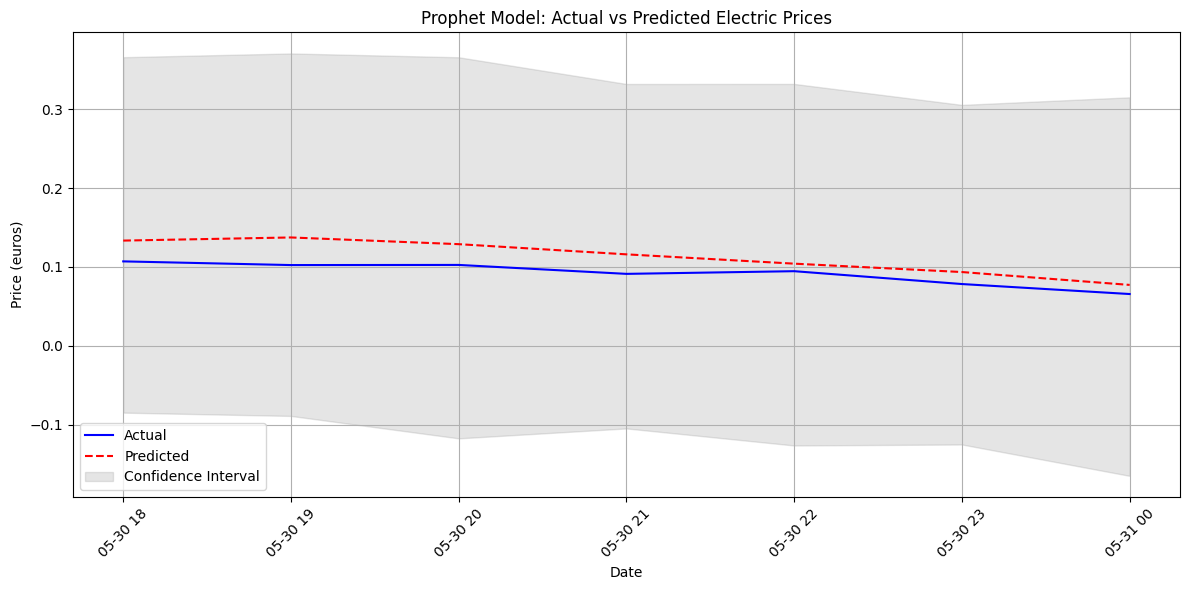

/home/david/proyectos4/p4_venv/lib/python3.10/site-packages/prophet/forecaster.py:1272: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['trend'] = self.predict_trend(df)


Mean Absolute Error (MAE): 0.0211
Root Mean Squared Error (RMSE): 0.0226
R² Score: -1.6828


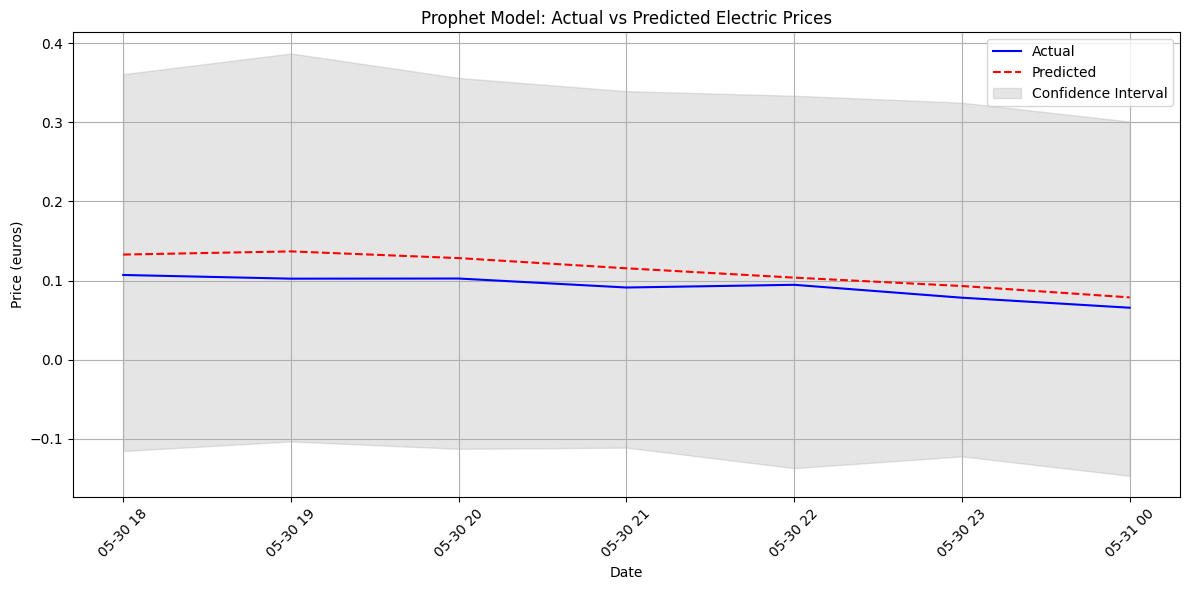

Modelo 1 (Algunos datos clima):
Mean Absolute Error (MAE): 0.021272
Root Mean Squared Error (RMSE): 0.022956
R² Score: -1.761115

Modelo 2 (Muchos datos clima):
Mean Absolute Error (MAE): 0.021052
Root Mean Squared Error (RMSE): 0.022628
R² Score: -1.682781

El Modelo 2 tiene un mejor desempeño (RMSE más bajo)


In [30]:
# Comparar los dos modelos
metrics1 = evaluate_prophet_model(m1, df_prophet_test)
metrics2 = evaluate_prophet_model(m2, df_prophet_test)

print("Modelo 1 (Algunos datos clima):")
print(f"Mean Absolute Error (MAE): {metrics1['mae']:.6f}")
print(f"Root Mean Squared Error (RMSE): {metrics1['rmse']:.6f}")
print(f"R² Score: {metrics1['r2']:.6f}")

print("\nModelo 2 (Muchos datos clima):")
print(f"Mean Absolute Error (MAE): {metrics2['mae']:.6f}")
print(f"Root Mean Squared Error (RMSE): {metrics2['rmse']:.6f}")
print(f"R² Score: {metrics2['r2']:.6f}")

# Compare which model is better
if metrics1['rmse'] < metrics2['rmse']:
    print("\nEl Modelo 1 tiene un mejor desempeño (RMSE más bajo)")
elif metrics2['rmse'] < metrics1['rmse']:
    print("\nEl Modelo 2 tiene un mejor desempeño (RMSE más bajo)")
else:
    print("\nAmbos modelos tienen un desempeño similar")

In [32]:
# Guardar los modelos
import pickle
import os

# Asegurarse de que el directorio existe
os.makedirs('models', exist_ok=True)

# Guardar los modelos usando pickle
with open('models/prophet_model1.pkl', 'wb') as f:
	pickle.dump(m1, f)
	
with open('models/prophet_model2.pkl', 'wb') as f:
	pickle.dump(m2, f)
	
print("Modelos guardados correctamente.")

Modelos guardados correctamente.
